In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn-v0_8")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import textwrap
import seaborn as sn
sn.color_palette("hls", 17)
import scipy.stats as st
import math

import pingouin as pg
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
import sys
import os
sys.path.append(os.path.join("..", "..", "..", ".."))

from mika.kd.trend_analysis import *
from mika.utils import Data

In [3]:
csv_file_name = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir, os.pardir)),'data','SAFECOM','SAFECOM_data.csv')
df = pd.read_csv(csv_file_name, dtype=str)
fire_missions = [mission for mission in list(df['Mission Type']) if type(mission) is str and 'fire' in mission.lower()]
df = df.loc[df['Mission Type'].isin(fire_missions)].reset_index(drop=True)
df['Year'] = [df.at[i,'Date'].split('/')[-1] for i in range(len(df))]
df['Day'] = [df.at[i,'Date'].split('/')[1] for i in range(len(df))]
df['Month'] = [df.at[i,'Date'].split('/')[0] for i in range(len(df))]
#df['Year'].value_counts()

In [4]:
#NIFC based in boise
#idaho and wyoming are split in regions
def correct_regions(df):
    region_dict ={
        'Region 05 Pacific Southwest Region': ['5', 'California', 'Hawaii', 'Pacific West Regional Office','California State Office','R2-Southwest Regional Office', 'National Guard'],
        'Region 06 Pacific Northwest Region':['Oregon/Washington State Office', 'Washington', 'Oregon', 'Washington Office','R9-Washington Office',
                                             'PNW Research Station FIA','R1-Pacific Regional Office'],
        'Region 01 Northern Rockies Region':['Montana/Dakotas State Office', 'Montana'], 
        'Region 04 Intermountain Region':['Nevada State Office','DOI-OAS - Headquarters Boise', 'Intermountain Regional NPS Headquarters',
                                         'Utah','Utah State Office', 'Nevada', 'National Interagency Fire Center', 'DOI-OAS - Western Region Office',
                                         'DOI-OAS - Technical Services', 'DOI-OAS - Unmanned Aircraft System Office'],
        'Region 03 Southwest Region':['Southeast Region','Arizona State Office','Arizona','New Mexico','New Mexico State Office'],
        'Region 09 Eastern Area Region':['New Jersey', 'Pennsylvania', 'Minnesota','Pennsylvania','Midwest Regional NPS Headquarters','R3-Great Lakes - Big Rivers Regional Office',
                                        'Northeast Regional Office', 'DOI-OAS - Eastern Region Office','Northeastern Area, S&PF','Wisconsin','Eastern States Office','National Capitol Parks'],
        'Region 02 Rocky Mountain Region':['Colorado State Office', 'Colorado','R6-Mountain-Praire Regional Office', 'DMBM - Migratory Birds', 'Wyoming', 'South Dakota'], 
        'Region 08 Southern Area Region':['Gulf of Mexico Region','Texas','Oklahoma','North Carolina', 'South Carolina','Florida','R4-Southeast Regional Office', 'Tennessee'],
        'Region 10 Alaska Region': ['Alaska State Office','Alaska OCS Region', 'Alaska Regional Office', 'Alaska','DOI-OAS - Alaska Regional Office',
                                   'R7-Alaska Regional Office']

    }
    regions_corrected = []
    indices_to_drop = []
    for i in range(len(df)):
        current_region = df.iloc[i]['Region']
        correct_region = None
        for region in region_dict:
            if (region == current_region) or (current_region in region_dict[region]):
                correct_region = region
                break 
        if not correct_region:
            correct_region = current_region
        if correct_region in ['CAMP â€“ Campaign Against Marijuana Program', 'Commercial Aircraft Services', 'Aircraft Operations Center','National Capitol Parks', 'Department of Defense', 'National Guard']:
            indices_to_drop.append(i)
        if correct_region == 'Idaho':
            if df.iloc[i]['Location'] in ['Clear Creak Fire', 'garden valley', 'Idaho City', 'Idaho City Helibase (U98)','Ranft Fire']:
                correct_region = 'Region 04 Intermountain Region'
            else:
                correct_region = 'Region 01 Northern Rockies Region'
        elif correct_region == 'Pacific Region':
            correct_region = 'Region 05 Pacific Southwest Region'
        elif correct_region == 'Idaho State Office':
            if df.iloc[i]['Location'] in ['Granite Creek Fire', '47.512775, -116.002886','Post Falls, ID']:
                correct_region = 'Region 01 Northern Rockies Region'
            else: 
                correct_region = 'Region 04 Intermountain Region'
        elif correct_region == 'Wyoming State Office':
            if df.iloc[i]['Location'] in ['Tokewanna Fire','Rock Springs Sweetwater County', 'Evanston, WY Airport']:
                correct_region = 'Region 04 Intermountain Region'
            else:
                correct_region = 'Region 02 Rocky Mountain Region'
        regions_corrected.append(correct_region)

    df['region_corrected'] = regions_corrected
    df = df.drop(indices_to_drop, axis=0).reset_index(drop=True)
    return df

In [5]:
list_of_attributes = ['Narrative']#, 'corrective_public', 'notes']
extra_cols = ['Agency', 'Region', 'Location', 'Date', 'Date Submitted', 'Tracking #',
              'Mission Type', 'Persons Onboard', 'Departure Point', 'Destination',
              'Special Use', 'Damages', 'Injuries', 'Hazardous Materials', 'Other Mission Type',
              'Type', 'Manufacturer', 'Model', 'Hazard', 'Incident Management',
              'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention'
              ]
document_id_col = 'Tracking #'

file = os.path.join('topic_model_results','preprocessed_data.csv')
safecom = Data()
safecom.load(file, preprocessed=True, id_col=document_id_col, text_columns=list_of_attributes)
preprocessed_df = safecom.data_df
preprocessed_df['Year'] = [preprocessed_df.at[i,'Date'].split('/')[-1] for i in range(len(preprocessed_df))]
preprocessed_df['Day'] = [preprocessed_df.at[i,'Date'].split('/')[1] for i in range(len(preprocessed_df))]
preprocessed_df['Month'] = [preprocessed_df.at[i,'Date'].split('/')[0] for i in range(len(preprocessed_df))]

In [6]:
preprocessed_df = preprocessed_df.loc[ preprocessed_df['Year'].astype(int)<2021].reset_index(drop=True)

In [7]:
hazard_file = os.path.join('topic_model_results', 'hazard_interpretation_SAFECOM_Final.xlsx')
results_file = os.path.join('topic_model_results','lda_results.xlsx')

In [8]:
#hazard_info = pd.read_excel(hazard_file, sheet_name=['topic-focused'])

In [9]:
#remove ids from results file and preprocessed_df if the mission is non-fire
non_fire_missions = [mission for mission in list(preprocessed_df['Mission Type']) if type(mission) is str and 'non-fire' in mission.lower()]
ids_to_drop = preprocessed_df.loc[preprocessed_df['Mission Type'].isin(non_fire_missions)]['Tracking #'].tolist()
print(len(ids_to_drop))

1986


In [10]:
def identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, text_field, time_field, id_field, results_text_field=None, doc_topic_dist_field=None, topic_thresh=0.0, ids_to_drop=[]):
    hazard_info = pd.read_excel(hazard_file, sheet_name=['topic-focused'])
    hazards = list(set(hazard_info['topic-focused']['Hazard name'].tolist()))
    hazards = [hazard for hazard in hazards if isinstance(hazard,str)]
    time_period = preprocessed_df[time_field].unique()
    categories = hazard_info['topic-focused']['Hazard Category'].tolist()
    if '.csv' in results_file:
        results = pd.read_csv(results_file)
        results = {results_text_field: results}
        doc_topic_distribution = None
    elif '.xlsx' in results_file:
        results = pd.read_excel(results_file, sheet_name=[text_field])
        doc_topic_distribution = pd.read_excel(results_file, sheet_name=[doc_topic_dist_field])[doc_topic_dist_field]
    if results_text_field == None:
        results_text_field = text_field
    frequency = {name:{str(time_p):0 for time_p in time_period} for name in hazards}
    docs_per_hazard = {hazard:{str(time_p):[] for time_p in time_period} for hazard in hazards}
    for i in range(len(hazards)):
        num_df = hazard_info['topic-focused'].loc[hazard_info['topic-focused']['Hazard name'] == hazards[i]].reset_index(drop=True)
        nums = [int(i) for nums in num_df['Topic Number'] for i in str(nums).split(", ")]#num_df['Topic Number'].to_list() #identifies all topics related to this hazard
        ids_df = results[results_text_field].loc[nums]
        ids_ = ids_df['documents'].to_list()
        ids_ = ids_[0].strip("[]").split(", ")
        ids_= [w.replace("'","") for w in ids_]
        ids_ = [id_ for id_ in ids_ if id_ not in ids_to_drop]
        # ids_ = ids_ only if topic nums > thres
        if doc_topic_distribution is not None:
            new_ids = []
            for id_ in ids_:
                #check that topic prob> thres for at least one num
                id_df = doc_topic_distribution.loc[doc_topic_distribution['document number']==id_].reset_index(drop=True)
                probs = [float(id_df.iloc[0][text_field].strip("[]").split(" ")[num].strip("\n")) for num in nums]
                max_prob = max(probs)
                if max_prob > topic_thresh:
                    new_ids.append(id_)
            ids_ = new_ids
         #print(ids_)
        temp_df = preprocessed_df.loc[preprocessed_df[id_field].astype(str).isin(ids_)].reset_index(drop=True)
        fire_ids = temp_df[id_field].unique()
        for id_ in fire_ids:
            temp_fire_df = temp_df.loc[temp_df[id_field]==id_].reset_index(drop=True)
            for j in range(len(temp_fire_df)):
                text = temp_fire_df.iloc[j][text_field]
                #check for hazard -- looks at the hazard relevant words from the topic
                hazard_name = hazards[i]
                #if id_ in fuel_ids and hazard_name in ['Fuel System Malfunction', 'Fuel Leak']:
                #    print(id_, hazard_name, text)
                hazard_words = num_df['Relevant hazard words'].to_list()
                hazard_words = [word for words in hazard_words for word in words.split(", ")]
                negation_words = num_df['Negation words'].to_list()
                negation_words = [word for word in negation_words if isinstance(word, str)]
                #need to check if a word in text is in hazard words
                hazard_found = False
                for word in hazard_words:
                    if word in text:
                        hazard_found = True
                        #if id_ in fuel_ids and hazard_name in ['Fuel System Malfunction', 'Fuel Leak']:
                        #    print(id_, text, hazard_found, word)

                if negation_words!=[]:
                    for words in negation_words:
                        for word in words.split(", "):#removes texts that have negation words
                            if word in text:
                                hazard_found = False 
                                #if id_ in fuel_ids and hazard_name in ['Fuel System Malfunction', 'Fuel Leak']:
                                #    print(id_, text, hazard_found, word)

                if hazard_found == True:
                    year = temp_fire_df.iloc[j][time_field]
                    docs_per_hazard[hazard_name][str(year)].append(id_)
                    frequency[hazard_name][str(year)] += 1
    return frequency, docs_per_hazard

In [11]:
frequency, docs = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Narrative', 'Year', "Tracking #", 'Narrative', doc_topic_dist_field='document topic distribution', topic_thresh=0.2,  ids_to_drop= ids_to_drop)

In [12]:
#_ = hazard_accuracy(docs, num=15, results_path=os.path.join(os.path.dirname(os.getcwd()),'results','SAFECOM_hazards_lda_topics_Apr-04-2022'))

In [13]:
#frequency, docs = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, 'Raw_Narrative', 'Year', "Tracking #", 'Narrative_reduced_BERT_topics')

In [14]:
def safecom_severity(passengers, injury, damage):
    key_dict = {"No":0, "Yes":1}
    if passengers == "":
        passengers = 0
    severity = float(passengers)*(key_dict[injury] + key_dict[damage])
    if np.isnan(severity):
        severity=0
    return severity

In [15]:
def create_table(docs, frequency, preprocessed_df, id_field, categories, subcategories, hazards, time_field, accuracy_file):
    table = pd.DataFrame({"Category": categories, "Subcategory": subcategories, "Hazards": hazards})
    accuracy_df = pd.read_excel(accuracy_file, sheet_name=['Summary'])['Summary']
    time_period = preprocessed_df[time_field].unique()
    severities = {name:{str(time_p):[] for time_p in time_period} for name in hazards}
    rates = {name:{str(time_p):0 for time_p in time_period} for name in hazards}
    total_docs_per_year = preprocessed_df[time_field].value_counts()
    total_rates = {hazard:0 for hazard in hazards}
    total_hazard_freq = {hazard:0 for hazard in hazards}
    total_severities_hazard = {hazard:0 for hazard in hazards}
    total_docs = len(preprocessed_df)
    precision = []
    for hazard in hazards:
        hazard_precision = accuracy_df.loc[accuracy_df['Hazards']==hazard].reset_index(drop=True)['Accuracy'].tolist()[0]
        precision.append(round(hazard_precision,3))
        for year in docs[hazard]:
            year = str(year)
            for doc in docs[hazard][year]:
                doc_df = preprocessed_df.loc[preprocessed_df[id_field] == doc].reset_index(drop=True)
                severities[hazard][year].append(safecom_severity(doc_df.iloc[0]['Persons Onboard'], doc_df.iloc[0]['Injuries'], doc_df.iloc[0]['Damages']))
            rates[hazard][year] = frequency[hazard][year]/total_docs_per_year[year]
            total_hazard_freq[hazard] += frequency[hazard][year]
        total_rates[hazard] = round(total_hazard_freq[hazard]/len(time_period), 3)
        total_severities_hazard[hazard] = round(np.average([sev for year in severities[hazard] for sev in severities[hazard][year]]),3)
    table["Frequency"] = [total_hazard_freq[hazard] for hazard in total_hazard_freq]
    table["Rate"] = [total_rates[hazard] for hazard in total_rates]
    table["Severity"] = [total_severities_hazard[hazard] for hazard in total_severities_hazard]
    table["Precision"] = precision
    return table, severities, rates
    

In [16]:
def get_categories_from_docs(docs, preprocessed_df, id_field, category_fields = ['Hazard', 'UAS', 'Accident', 'Airspace', 'Maintenance', 'Mishap Prevention']):
    categories = {hazard: [] for hazard in docs}
    sub_categories = {hazard: [] for hazard in docs}
    for hazard in docs:
        ids = [id_ for year in docs[hazard] for id_ in docs[hazard][year]]
        hazard_df = preprocessed_df.loc[preprocessed_df[id_field].isin(ids)].reset_index(drop=True)
        #main category is the category with the most reports
        cat_counts = {}
        for cat in category_fields:
            cat_counts[cat] = len(hazard_df.loc[hazard_df[cat].notna()])
        main_category = max(cat_counts, key=cat_counts.get)
        categories[hazard] = main_category
        #subcategories are the most common value in that catgeory
        #subcats = hazard_df[main_category].value_counts()
        #print(subcats)
        if len(hazard_df[main_category].value_counts()) == 0:
            sub_categories[hazard] = ""
        else:
            sub_cats = hazard_df[main_category].tolist()
            sub_cats = [cat for sub_cat in sub_cats for cat in str(sub_cat).split(", ")]
            sub_cats =[cat for cat in sub_cats if cat != 'nan']
            sub_cat_series = pd.Series(sub_cats).dropna()
            #sub_cat_series = sub_cat_series.loc[sub_cat_series.notna()].reset_index(drop=True)
            #print(sub_cat_series.value_counts())
            sub_categories[hazard] = sub_cat_series.value_counts().idxmax(axis = 0)#hazard_df[main_category].value_counts().idxmax(axis = 0)#list(hazard_df[main_category].value_counts())
            #sub_categories[hazard] = hazard_df[main_category].value_counts().idxmax(axis = 0)
            #print(hazard_df[main_category].value_counts())
    return categories, sub_categories

In [17]:
hazards_to_drop = ['Runway Hazards', 'Runway Collisions', 'Refuel Truck Problems']
hazards = [hazard for hazard in frequency if hazard not in hazards_to_drop]
docs = {hazard:docs[hazard] for hazard in hazards}
categories, sub_categories = get_categories_from_docs(docs, preprocessed_df, "Tracking #")
categories = categories.values()
subcategories = sub_categories.values()
accuracy_file = os.path.join('topic_model_results', 'hazard_extraction_accuracy_final.xlsx')
table, severities, rates = create_table(docs, frequency, preprocessed_df, "Tracking #", categories, subcategories, hazards, 'Year', accuracy_file)

In [18]:
table = table.sort_values(['Category', 'Subcategory'], axis=0).reset_index(drop=True)
df = table[['Category', 'Subcategory']]
ind = pd.MultiIndex.from_frame(df)
table.index = ind
table = table.drop(['Category', 'Subcategory'], axis=1)

In [19]:
table

Hazards  Frequency  \
Category Subcategory                                                       
Hazard                                         Severe Weather        158   
                                      Fuel System Malfunction         42   
                                          Bucket Drop Failure       1063   
                                          In-flight Collision         23   
                                              Oil Malfunction        194   
                                         Hydraulic Fluid Leak        258   
                                                      Medivac         41   
                                                 Door Failure        479   
                                    Jumper Operations Hazards         57   
                           On-board Caution Light Illuminates        129   
                                     Landing Gear Malfunction        204   
                                     Airspace Control Hazards         68   
                                        Cargo Letdown Failure        459   
                                 Helitorch Operations Failure         35   
                                       Tanker Loading Failure         84   
                                           Engine Malfunction        673   
                                         Avionics Malfunction        367   
                                       Control Surface Damage        405   
                                         Load Limits Exceeded         46   
                                                    Intrusion        227   
         Communications                     Radio Malfunction         21   
         Policy Deviation                      Inadequate PPE         35   
         Policy Deviation       Personnel Duty Hours Exceeded         77   

                             Rate  Severity  Precision  
Category Subcategory                                    
Hazard                      5.852     0.848      0.800  
                            1.556     0.048      0.733  
                           39.370     0.464      0.733  
                            0.852     0.783      0.800  
                            7.185     0.000      1.000  
                            9.556     0.147      0.933  
                            1.519     1.512      1.000  
                           17.741     0.706      0.867  
                            2.111     3.561      0.800  
                            4.778     0.054      1.000  
                            7.556     0.181      0.933  
                            2.519     0.029      0.800  
                           17.000     0.229      0.800  
                            1.296     0.171      0.800  
                            3.111     0.214      0.733  
                           24.926     0.048      0.933  
                           13.593     0.125      0.933  
                           15.000     0.551      0.800  
                            1.704     0.065      0.867  
                            8.407     0.000      1.000  
         Communications     0.778     0.238      0.933  
         Policy Deviation   1.296     0.000      0.800  
         Policy Deviation   2.852     0.026      0.800

In [20]:
#table.to_csv(os.path.join('SAFECOM_hazards.csv'))

In [21]:
average_precision = np.average(table['Precision'].tolist())
std_precision = np.std(table['Precision'].tolist())
print(average_precision, std_precision)

0.8607826086956523 0.08990717750606872


In [22]:
docs_per_hazard = {hazard:[doc for year in docs[hazard] for doc in docs[hazard][year]] for hazard in docs}

In [23]:
hazards = []; tracking_num = []

In [24]:
for hazard in docs_per_hazard:
    for num in docs_per_hazard[hazard]:
        hazards.append(hazard)
        tracking_num.append(num)
hazard_docs_df = pd.DataFrame({"Hazard":hazards,
                              "Tracking #": tracking_num})

In [25]:
#hazard_docs_df.to_csv(os.path.join('topic_model_results','hazard_docs.csv'))

In [26]:
#print(table.to_latex())

In [27]:
hazards_for_analysis = ['Hydraulic Fluid Leak', 'Intrusion', 'Bucket Drop Failure','Radio Malfunction',
                       'Jumper Operations Hazards', 'Tanker Loading Failure', 'Helitorch Operations Failure',
                       'Cargo Letdown Failure', 'Severe Weather']

In [28]:
#updat: frequency, docs, severities, rates, hazards
frequency = {hazard: frequency[hazard] for hazard in hazards_for_analysis}
docs = {hazard: docs[hazard] for hazard in hazards_for_analysis}
severities = {hazard: severities[hazard] for hazard in hazards_for_analysis}
rates = {hazard: rates[hazard] for hazard in hazards_for_analysis}
hazards = hazards_for_analysis

In [29]:
def plot_metric_time_series(metric_data, metric_name, line_styles=[], markers=[], title="", time_name="Year", scaled=False, xtick_freq=5, show_std=True, save=False):
    time_vals = list(set([year for hazard in metric_data for year in metric_data[hazard]]))
    time_vals.sort()
    #scaled -> scaled the averages, how to scale stddev?
    if scaled: metric_data = {hazard: minmax_scale(metric_data[hazard]) for hazard in metric_data}
    averages = {hazard: [np.average(metric_data[hazard][year]) for year in time_vals] for hazard in metric_data}
    stddevs = {hazard: [np.std(metric_data[hazard][year]) for year in time_vals] for hazard in metric_data}
    colors = cm.tab10(np.linspace(0, 1, len(averages)))
    plt.figure()
    plt.title(title, fontsize=16)
    plt.xlabel(time_name, fontsize=16)
    plt.ylabel(metric_name, fontsize=16)
    plt.yscale('symlog')
    i=0
    for hazard in averages:
        if show_std == True:
            plt.errorbar(time_vals, averages[hazard], yerr=stddevs[hazard], color=colors[i], marker=markers[i], linestyle=line_styles[i], label=hazard, capsize=5, markeredgewidth=1)
        else:
            plt.plot(time_vals, averages[hazard], color=colors[i], marker=markers[i], linestyle=line_styles[i], label=hazard)
        i += 1
    plt.legend(bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=14)
    plt.xticks(np.arange(1, int(len(time_vals))+1, xtick_freq),rotation=45)
    plt.tick_params(labelsize=16)
    plt.savefig('SAFECOM_hazard_'+metric_name+'.pdf', bbox_inches="tight") 
    plt.show()

def plot_metric_averages(metric_data, metric_name, show_std=True, title="", save=False, legend=True):
    avg = {hazard: np.average([m for year in metric_data[hazard] for m in metric_data[hazard][year]]) for hazard in metric_data}
    stddev = {hazard: np.std([m for year in metric_data[hazard] for m in metric_data[hazard][year]]) for hazard in metric_data}
    x_pos = np.arange(len(metric_data))
    fig, ax = plt.subplots()
    colors = cm.tab10(np.linspace(0, 1, len(metric_data)))
    labels = [key for key in metric_data.keys()]
    ax.bar(x_pos, avg.values(), yerr=stddev.values(), align='center', ecolor='black', capsize=10, color=colors)
    plt.xlabel("Hazard", fontsize=16)
    plt.ylabel(metric_name, fontsize=16)
    plt.title(title, fontsize=16)
    ax.yaxis.grid(True)
    plt.tick_params(labelsize=14)
    if legend == True:
        ax.set_xticklabels([])
        handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
        plt.legend(handles, labels, bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=14)
    elif legend == False:
        labels = list(metric_data.keys())
        mean_length = np.mean([len(i) for i in labels])
        labels = ["\n".join(textwrap.wrap(i,mean_length)) for i in labels]
        ax.set_xticks(np.asarray([i for i in range(len(metric_data))]))
        ax.set_xticklabels(labels,rotation=45,ha="right",rotation_mode='anchor')
    plt.savefig('SAFECOM_hazard_bar_'+metric_name+'.pdf', bbox_inches="tight") 
    plt.show()

In [30]:
def plot_frequency_time_series(metric_data, metric_name='Frequency', line_styles=[], markers=[], title="", time_name="Year", xtick_freq=5, scale=True, save=False):
    time_vals = list(set([year for hazard in metric_data for year in metric_data[hazard]]))
    time_vals.sort()
    frequencies = {hazard: [metric_data[hazard][year] for year in time_vals] for hazard in metric_data}
    if scale==True:
        hazard_freqs_scaled = {hazard: minmax_scale(frequencies[hazard]) for hazard in frequencies}
        y_label = "Total Scaled "+metric_name
    else:
        hazard_freqs_scaled = frequencies
        y_label = metric_name
    colors = cm.tab10(np.linspace(0, 1, len(frequencies)))
    plt.figure()
    plt.ylabel(y_label, fontsize=16)
    plt.xlabel(time_name, fontsize=16)
    plt.title(title, fontsize=16)
    i = 0
    for hazard in hazard_freqs_scaled:
        plt.plot(time_vals, hazard_freqs_scaled[hazard], color=colors[i], label=hazard, marker=markers[i], linestyle=line_styles[i])
        i += 1
    #plt.legend(bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=14)
    plt.xticks(np.arange(1, int(len(time_vals))+1, xtick_freq),rotation=45)
    plt.tick_params(labelsize=16)
    plt.savefig('SAFECOM_hazard_'+metric_name+'.pdf', bbox_inches="tight") 
    plt.show()

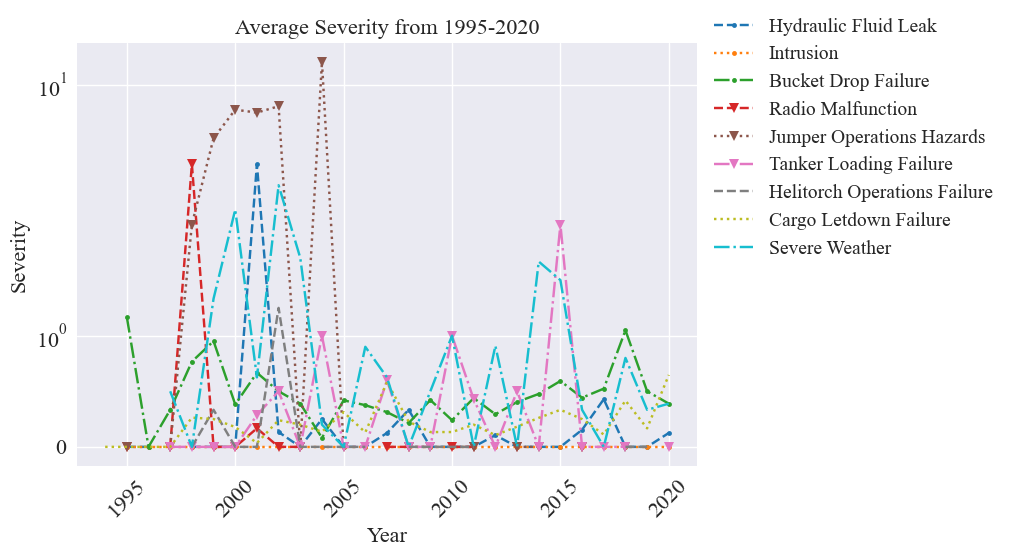

In [31]:
markers = ['.','.','.', 'v', 'v','v', 'x', 'x', 'x']
line_styles = ['--', ':','-.','--', ':','-.','--', ':','-.']

plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="Average Severity from 1995-2020", time_name='Year', show_std=False, save=False)
#plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="Average Severity from 1995-2020", time_name='Year', show_std=True, save=False)

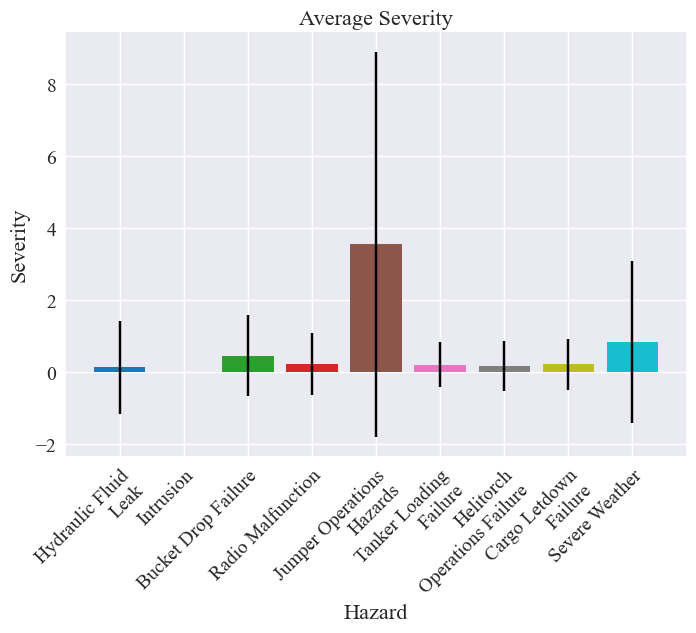

In [32]:
plot_metric_averages(metric_data=severities, metric_name="Severity", show_std=True, title="Average Severity", save=False, legend=False)

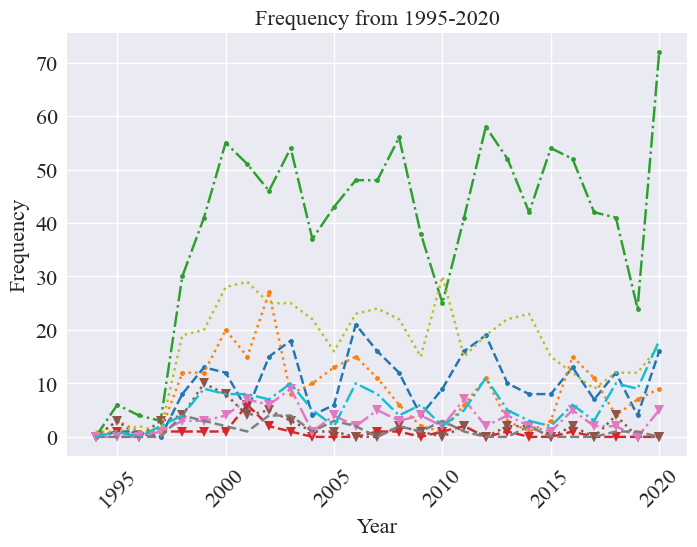

In [33]:
plot_frequency_time_series(frequency, metric_name='Frequency', line_styles=line_styles, markers=markers, title="Frequency from 1995-2020", time_name="Year", scale=False)

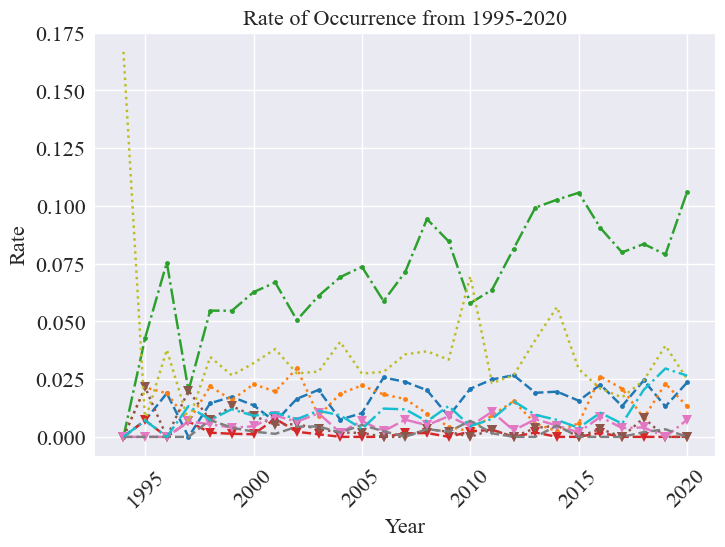

In [34]:
plot_frequency_time_series(rates, metric_name='Rate', line_styles=line_styles, markers=markers, title="Rate of Occurrence from 1995-2020", time_name="Year", scale=False, save=False)

# Pie Charts

In [35]:
def make_pie_chart(docs, data, predictor, hazards, id_field, predictor_label=None, save=False):
    if not predictor_label: predictor_label=predictor
    num_rows = int(np.ceil(len(hazards)/3))
    extra_axes = len(hazards)%3
    fig, axes = plt.subplots(num_rows, 3, figsize=(17,9))
    if extra_axes>0:
        for x in range(1,extra_axes):
            fig.delaxes(axes[num_rows-1][3-x])
    #set up lables, colors dict
    total_docs_with_hazards = [doc for hazard in hazards for year in docs[hazard] for doc in docs[hazard][year] ]
    labels = data.loc[data[id_field].isin(total_docs_with_hazards)][predictor].value_counts().index.sort_values()
    colors = cm.coolwarm(np.linspace(0, 1, len(labels)))
    for ax, hazard in zip(axes.flatten(), hazards):
        total_docs = [doc for year in docs[hazard] for doc in docs[hazard][year]]
        hazard_data = data.loc[data[id_field].isin(total_docs)].reset_index(drop=True)
        #label = hazard_data[predictor].value_counts().index.sort_values()
        #print(label)
        val_counts = hazard_data[predictor].value_counts()
        values = [val_counts[val] if val in val_counts else 0 for val in labels]
        #colors = cm.coolwarm(np.linspace(0, 1, len(label)))
        _, _, autopct = ax.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 12},labeldistance=None, pctdistance=1.2)
        for txt in autopct:
            if float(txt.get_text().strip("%"))<3.0:
                txt.set_visible(False)
                
        ax.set_title(hazard+" per "+predictor_label, fontdict={'fontsize': 14})
    axes[0,0].legend(bbox_to_anchor=(-0.2, 1),fontsize=14)
    plt.savefig('SAFECOM_hazard_'+predictor+'.pdf', bbox_inches="tight") 
    plt.show()

In [36]:
correct_regions(preprocessed_df)

,Agency,Region,Location,Date,Date Submitted,Tracking #,Mission Type,Persons Onboard,Departure Point,Destination,...,UAS,Accident,Airspace,Maintenance,Mishap Prevention,Raw_Narrative,Year,Day,Month,region_corrected
0,Bureau of Land Management (BLM),Alaska State Office,Fairbanks,05/10/1995,,95-0002,"Fire, Smokejumper",1.0,Fairbanks,,...,,,Intrusion,,,On a practice parachute jump a single engine a...,1995,10,05,Region 10 Alaska Region
1,Bureau of Land Management (BLM),Alaska State Office,Fort Wainwright,05/10/1995,,95-0003,"Fire, Smokejumper",4.0,Birch Hill,,...,,,Intrusion,,,NXXXXX 5-10-95 A small airplane flew thr...,1995,10,05,Region 10 Alaska Region
2,Bureau of Land Management (BLM),Alaska State Office,Fort Wainwright,05/09/1995,,95-0004,"Fire, Air Attack",2.0,Fort Wainwright,,...,,,,Electrical,,"After takeoff from Ft. Wainwight, left generat...",1995,09,05,Region 10 Alaska Region
3,Bureau of Land Management (BLM),California State Office,BFL,07/28/1995,,95-0006,"Fire, Air Attack",2.0,BFL CA.,,...,,,,Hydraulic,,Firewall fitting cracked - leaking hydraulic f...,1995,28,07,Region 05 Pacific Southwest Region
4,Bureau of Land Management (BLM),Alaska State Office,6 Mi East of FBK,07/16/1995,,95-0007,Ferry/Repositioning Flight (Non-Fire),2.0,FBK,BOI,...,,,,,,I have debated with myself if I should file a ...,1995,16,07,Region 10 Alaska Region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14534,State,California,McClellan Reload Base,12/20/2020,,21-0151,"Fire, Leadplane",0.0,,,...,,,,,,"Prior to pilots' preflight, ATS noticed eviden...",2020,20,12,Region 05 Pacific Southwest Region
14535,State,California,Hemet Airport,12/24/2020,,21-0152,"Fire, Retardant Drop (Airtanker)",1.0,KHMT,KRNM,...,,,,,,While fueling at Ramona AAB after 2.5 hour fue...,2020,24,12,Region 05 Pacific Southwest Region
14536,State,California,Camp Pendleton,12/24/2020,,21-0154,"Fire, Water Drop (Helicopter Fixed-Tank)",3.0,KCRQ,Creek Fire Camp Pendleton,...,,,,,,While engaged in a water dropping mission HT-7...,2020,24,12,Region 05 Pacific Southwest Region
14537,U.S. Geological Survey (USGS),,Hawaii Volcanoes National Park,12/29/2020,,21-0155,Survey/Observation (Non-Fire),0.0,"Crater Rim Dr., west of Kilauea Caldera","Crater Rim Dr., west of Kilauea Caldera",...,"UAS, Fleet Operation, Loss of Link",,,,,A team of two pilots began flying on Crater Ri...,2020,29,12,


In [37]:
print(preprocessed_df.loc[preprocessed_df['region_corrected']=='National Guard'])

Empty DataFrame
Columns: [Agency, Region, Location, Date, Date Submitted, Tracking #, Mission Type, Persons Onboard, Departure Point, Destination, Special Use, Damages, Injuries, Hazardous Materials, Other Mission Type, Type, Manufacturer, Model, Narrative, Hazard, UAS, Accident, Airspace, Maintenance, Mishap Prevention, Raw_Narrative, Year, Day, Month, region_corrected]
Index: []

[0 rows x 30 columns]


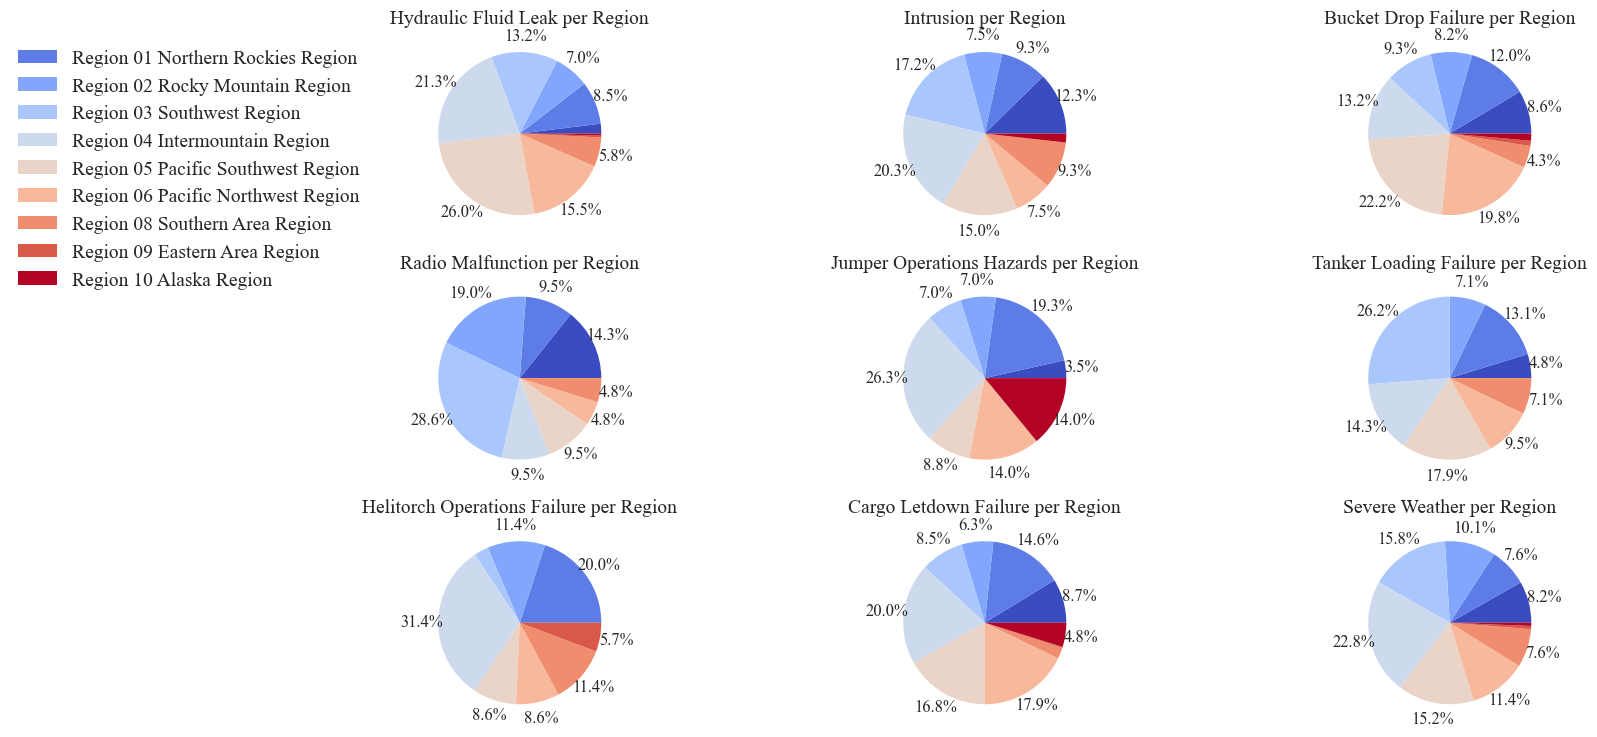

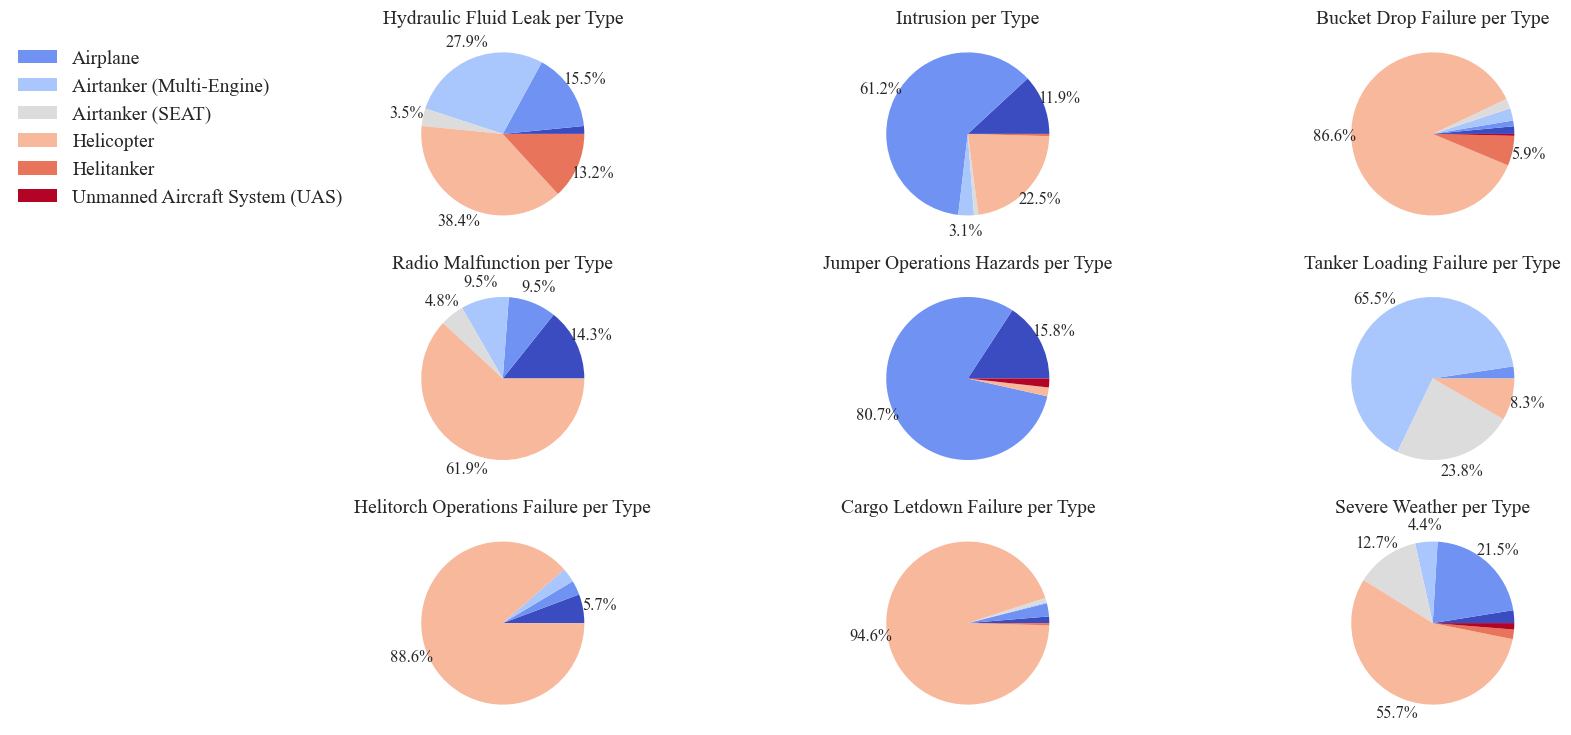

In [38]:
predictors = ['region_corrected', 'Type']#, 'Manufacturer', 'Model','Mission Type']
for predictor in predictors:
    if predictor == 'region_corrected': 
        predictor_label='Region'
    else:
        predictor_label = None
    make_pie_chart(docs, preprocessed_df, predictor, hazards, 'Tracking #', predictor_label)

# Chi-Squared Analysis

In [39]:
#add hazard values to preprocessed_df
hazards_per_doc = {doc:[] for doc in preprocessed_df['Tracking #']}
hazards_col = ["None" for i in range(len(preprocessed_df))]
hazards_for_df = {hazard:[0 for i in range(len(preprocessed_df))] for hazard in docs}
for hazard in docs:
    for year in docs[hazard]:
        for doc in docs[hazard][year]:
            hazards_for_df[hazard][preprocessed_df.index[preprocessed_df['Tracking #']==doc].tolist()[0]] = 1
            if hazards_col[preprocessed_df.index[preprocessed_df['Tracking #']==doc][0]] =="None":
                hazards_col[preprocessed_df.index[preprocessed_df['Tracking #']==doc][0]] = hazard
            else:
                hazards_col[preprocessed_df.index[preprocessed_df['Tracking #']==doc][0]] += hazard
    preprocessed_df[hazard] = hazards_for_df[hazard]
preprocessed_df['hazard'] = hazards_col
#add severities
severities = []
for i in range(len(preprocessed_df)):
    severities.append(safecom_severity(preprocessed_df.iloc[i]['Persons Onboard'], preprocessed_df.iloc[i]['Injuries'], preprocessed_df.iloc[i]['Damages']))
preprocessed_df["severity"] = severities

In [40]:
count_dfs = {}
pred_dict = {'region_corrected':'Region', 'Type': "Aircraft Type", 'Agency':'Agency'}
stat_vals = {(pred_dict[pred],val): [] for pred in predictors for val in ["chi-squared", "p-val"]}
for predictor in predictors:
    vals = []
    hazard_vals = []
    pred_vals = [val for val in preprocessed_df[predictor].value_counts().index]
    diff_observed_expected = {pred_val:[] for pred_val in pred_vals}
    for hazard in hazards:
        expected, observed, stats = pg.chi2_independence(preprocessed_df, x=predictor,y=hazard)
        stat_vals[(pred_dict[predictor], "p-val")].append((stats.iloc[0]['pval'].round(3)))
        stat_vals[(pred_dict[predictor], "chi-squared")].append((stats.iloc[0]['chi2'].round(3)))
        for i in range(len(expected)):
            pred_val = expected.index[i]
            diff_observed_expected[pred_val].append(observed.iloc[i][0] - expected.iloc[i][0])
            diff_observed_expected[pred_val].append(observed.iloc[i][1] - expected.iloc[i][1])
    iterables = [hazards, [0,1]]
    index = pd.MultiIndex.from_product(iterables, names=["Hazard", "Present"])
    pred_df = pd.DataFrame(diff_observed_expected, index=index)
    count_dfs[predictor] = pred_df
iterables = [[pred_dict[pred] for pred in predictors], ["p-val", "chi-squared"]]
index = pd.MultiIndex.from_product(iterables, names=["Predictor", "Measure"])
stats_df = pd.DataFrame(stat_vals, index=hazards, columns=index)

In [41]:
stats_df

Predictor                    Region             Aircraft Type            
Measure                       p-val chi-squared         p-val chi-squared
Hydraulic Fluid Leak          0.000      51.951         0.000     152.536
Intrusion                     0.004      33.527         0.000     267.663
Bucket Drop Failure           0.000     123.147         0.000     637.236
Radio Malfunction             0.481      14.591         0.056      12.261
Jumper Operations Hazards     0.031      26.767         0.000     150.454
Tanker Loading Failure        0.013      29.588         0.000     321.814
Helitorch Operations Failure  0.027      27.196         0.002      21.445
Cargo Letdown Failure         0.000      57.108         0.000     336.246
Severe Weather                0.105      22.094         0.000      33.793

In [42]:
#print(stats_df.to_latex())

In [43]:
for df in count_dfs:
    display(count_dfs[df])

Region 05 Pacific Southwest Region  \
Hazard                       Present                                       
Hydraulic Fluid Leak         0                                -20.573128   
                             1                                 20.573128   
Intrusion                    0                                  6.848449   
                             1                                 -6.848449   
Bucket Drop Failure          0                                -44.714089   
                             1                                 44.714089   
Radio Malfunction            0                                  1.778931   
                             1                                 -1.778931   
Jumper Operations Hazards    0                                  5.257100   
                             1                                 -5.257100   
Tanker Loading Failure       0                                  0.115726   
                             1                                 -0.115726   
Helitorch Operations Failure 0                                  3.298219   
                             1                                 -3.298219   
Cargo Letdown Failure        0                                  5.596644   
                             1                                 -5.596644   
Severe Weather               0                                  4.431960   
                             1                                 -4.431960   

                                      Region 04 Intermountain Region  \
Hazard                       Present                                   
Hydraulic Fluid Leak         0                            -15.296775   
                             1                             15.296775   
Intrusion                    0                            -11.067318   
                             1                             11.067318   
Bucket Drop Failure          0                             23.583442   
                             1                            -23.583442   
Radio Malfunction            0                              1.231658   
                             1                             -1.231658   
Jumper Operations Hazards    0                             -6.228357   
                             1                              6.228357   
Tanker Loading Failure       0                              0.926631   
                             1                             -0.926631   
Helitorch Operations Failure 0                             -5.613904   
                             1                              5.613904   
Cargo Letdown Failure        0                            -21.365193   
                             1                             21.365193   
Severe Weather               0                            -11.685622   
                             1                             11.685622   

                                      Region 06 Pacific Northwest Region  \
Hazard                       Present                                       
Hydraulic Fluid Leak         0                                 -4.306127   
                             1                                  4.306127   
Intrusion                    0                                 14.405075   
                             1                                -14.405075   
Bucket Drop Failure          0                                -62.935708   
                             1                                 62.935708   
Radio Malfunction            0                                  1.905315   
                             1                                 -1.905315   
Jumper Operations Hazards    0                                 -0.114144   
                             1                                  0.114144   
Tanker Loading Failure       0                                  3.621261   
                             1                                 -3.621261   
Helitorch Op

Helicopter    Airplane  \
Hazard                       Present                           
Hydraulic Fluid Leak         0         36.803479   21.417589   
                             1        -36.803479  -21.417589   
Intrusion                    0         68.486007  -84.962044   
                             1        -68.486007   84.962044   
Bucket Drop Failure          0       -361.468610  241.049990   
                             1        361.468610 -241.049990   
Radio Malfunction            0         -1.946228    2.999106   
                             1          1.946228   -2.999106   
Jumper Operations Hazards    0         29.003094  -32.430998   
                             1        -29.003094   32.430998   
Tanker Loading Failure       0         37.215086   17.996424   
                             1        -37.215086  -17.996424   
Helitorch Operations Failure 0        -12.577047    7.331843   
                             1         12.577047   -7.331843   
Cargo Letdown Failure        0       -192.396136   97.266176   
                             1        192.396136  -97.266176   
Severe Weather               0         -4.833528    3.612322   
                             1          4.833528   -3.612322   

                                      Airtanker (Multi-Engine)  \
Hazard                       Present                             
Hydraulic Fluid Leak         0                      -40.758991   
                             1                       40.758991   
Intrusion                    0                       20.487245   
                             1                      -20.487245   
Bucket Drop Failure          0                      102.717802   
                             1                     -102.717802   
Radio Malfunction            0                        0.542873   
                             1                       -0.542873   
Jumper Operations Hazards    0                        6.902083   
                             1                       -6.902083   
Tanker Loading Failure       0                      -44.828509   
                             1                       44.828509   
Helitorch Operations Failure 0                        3.238121   
                             1                       -3.238121   
Cargo Letdown Failure        0                       54.579935   
                             1                      -54.579935   
Severe Weather               0                       12.132091   
                             1                      -12.132091   

                                      Airtanker (SEAT)  Helitanker             \
Hazard                       Present                                            
Hydraulic Fluid Leak         0                2.673245  -25.413601   3.610672   
                             1               -2.673245   25.413601  -3.610672   
Intrusion                    0                8.270646    6.554700 -20.303789   
                             1               -8.270646   -6.554700  20.303789   
Bucket Drop Failure          0               27.095579  -27.622705  15.357148   
                             1              -27.095579   27.622705 -15.357148   
Radio Malfunction            0               -0.049852    0.698893  -2.380527   
                             1                0.049852   -0.698893   2.380527   
Jumper Operations Hazards    0                2.578973    1.896995  -7.318573   
                             1               -2.578973   -1.896995   7.318573   
Tanker Loading Failure       0              -16.199409    2.795572   2.477893   
                             1               16.199409   -2.795572  -2.477893   
Helitorch Operations Failure 0                1.583580    1.164822  -0.967545   
                             1               -1.583580   -1.164822   0.967545   
Cargo Letdown Failure        0               16.767517   13.275803   7.539916   
                             1              -16.767517  -13

# ANOVA 

In [44]:
severities_dict = {hazard:[] for hazard in hazards}
AOV_df = {'hazard':[], 'severity':[]}
for hazard in hazards:
    hazard_df = preprocessed_df.loc[preprocessed_df[hazard] == 1]
    sevs = hazard_df['severity'].tolist()
    severities_dict[hazard] = sevs
    for sev in sevs:
        AOV_df['hazard'].append(hazard)
        AOV_df['severity'].append(sev)
AOV_df = pd.DataFrame(AOV_df)

In [45]:
anovas = []
for hazard in hazards:
    aov = pg.welch_anova(dv='severity', between=hazard, data=preprocessed_df).round(3)
    anovas.append(aov)
anova_results = pd.concat(anovas)
anova_results

,Source,ddof1,ddof2,F,p-unc,np2
0,Hydraulic Fluid Leak,1,262.136,0.635,0.426,0.000
0,Intrusion,1,14315.000,690.648,0.000,0.001
0,Bucket Drop Failure,1,1184.473,59.189,0.000,0.005
0,Radio Malfunction,1,20.069,0.020,0.889,0.000
0,Jumper Operations Hazards,1,56.012,22.184,0.000,0.047
0,Tanker Loading Failure,1,85.354,0.003,0.958,0.000
0,Helitorch Operations Failure,1,34.308,0.108,0.744,0.000
0,Cargo Letdown Failure,1,515.343,0.296,0.586,0.000
0,Severe Weather,1,157.598,12.814,0.000,0.005


In [46]:
aov = pg.welch_anova(dv='severity', between='hazard', data=AOV_df).round(3)

In [47]:
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,hazard,8,217.328,35.677,0.0,0.13


In [48]:
print(aov.to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &  Source &  ddof1 &    ddof2 &       F &  p-unc &   np2 \\
\midrule
0 &  hazard &      8 &  217.328 &  35.677 &    0.0 &  0.13 \\
\bottomrule
\end{tabular}



In [49]:
post_hoc = pg.pairwise_gameshowell(dv='severity', between='hazard',  data=AOV_df).round(3)

In [50]:
post_hoc = post_hoc.loc[post_hoc['pval']<0.05].reset_index(drop=True)

In [51]:
post_hoc = post_hoc[['A', 'B', 'df', 'T', 'pval', 'hedges']]
post_hoc.index = post_hoc['A']
post_hoc = post_hoc.drop(['A'], axis=1)
post_hoc

,B,df,T,pval,hedges
A,,,,,
Bucket Drop Failure,Cargo Letdown Failure,1316.583,4.900,0.000,0.230
Bucket Drop Failure,Hydraulic Fluid Leak,357.195,3.611,0.010,0.273
Bucket Drop Failure,Intrusion,1062.000,13.430,0.000,0.453
Bucket Drop Failure,Jumper Operations Hazards,56.262,-4.332,0.002,-1.898
Bucket Drop Failure,Tanker Loading Failure,130.812,3.275,0.035,0.227
Cargo Letdown Failure,Intrusion,458.000,6.872,0.000,0.392
Cargo Letdown Failure,Jumper Operations Hazards,56.244,-4.661,0.001,-1.749
Cargo Letdown Failure,Severe Weather,167.875,-3.386,0.024,-0.477
Helitorch Operations Failure,Jumper Operations Hazards,59.099,-4.682,0.001,-0.786


In [52]:
print(post_hoc.to_latex())

\begin{tabular}{llrrrr}
\toprule
{} &                          B &        df &       T &   pval &  hedges \\
A                            &                            &           &         &        &         \\
\midrule
Bucket Drop Failure          &      Cargo Letdown Failure &  1316.583 &   4.900 &  0.000 &   0.230 \\
Bucket Drop Failure          &       Hydraulic Fluid Leak &   357.195 &   3.611 &  0.010 &   0.273 \\
Bucket Drop Failure          &                  Intrusion &  1062.000 &  13.430 &  0.000 &   0.453 \\
Bucket Drop Failure          &  Jumper Operations Hazards &    56.262 &  -4.332 &  0.002 &  -1.898 \\
Bucket Drop Failure          &     Tanker Loading Failure &   130.812 &   3.275 &  0.035 &   0.227 \\
Cargo Letdown Failure        &                  Intrusion &   458.000 &   6.872 &  0.000 &   0.392 \\
Cargo Letdown Failure        &  Jumper Operations Hazards &    56.244 &  -4.661 &  0.001 &  -1.749 \\
Cargo Letdown Failure        &             Severe Weather &   167.

# Risk Matrix

In [53]:
def get_severity_FAA(severities): #SAFECOM
    curr_severities = {hazard:0 for hazard in severities}
    for hazard in severities:
        s = severities[hazard]
        if s<=0.1: #negligible impact
            severity = 'Minimal Impact'
        elif s>0.1 and s <= 0.5:
            severity = 'Minor Impact'
        elif s>0.5 and s<=1:
            severity = 'Major Impact'
        elif s>1 and s<=2:
            severity = 'Hazardous Impact'
        elif s>2:
            severity = 'Catastrophic Impact'
        curr_severities[hazard] = severity
    return curr_severities

In [54]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["font.family"] = "Arial"

In [55]:
severities = table['Severity']
severities.index = table['Hazards']
severities = severities[hazards]
severities = severities.to_dict()
severities = get_severity_FAA(severities)
rates = table['Rate']
rates.index = table['Hazards']
rates = rates[hazards]
rates = rates.to_dict()
rates = {hazard:float(rates[hazard]) for hazard in rates}
rates = get_likelihood_FAA(rates)

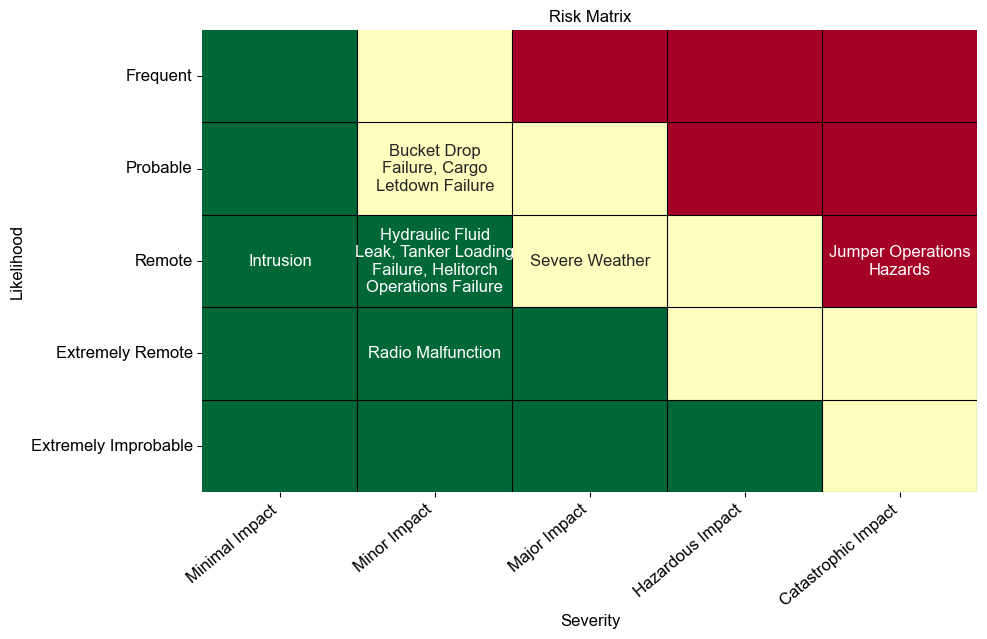

In [56]:
plot_risk_matrix(rates, severities, figsize=(10,6), save=False, results_path=os.path.join("SAFECOM_Aviation_rm"))